In [223]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader, random_split
from torch.nn import functional as F
import random
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms, datasets, models
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
os.environ['CUDA_VISIBLE_DEVICES'] = '4'
import sys
sys.path.append("/home/sipl-prj10364/.local/lib/python3.11.9/site-packages")

#import pywt
import numpy as np
import pandas as pd
import pickle
import scipy
from scipy.signal import butter, filtfilt, stft, correlate, convolve
from tqdm import tqdm
from IPython.display import clear_output
from matplotlib.animation import FuncAnimation
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as ticker
import scipy.io
from sklearn.metrics import confusion_matrix
from PIL import Image
from tempfile import TemporaryDirectory
import time
from sklearn.metrics import accuracy_score

# from anam
from lightly.loss import NTXentLoss
from lightly.models.modules import SimCLRProjectionHead
from lightly.transforms.simclr_transform import SimCLRTransform
from lightly import loss
from lightly import transforms
from lightly.data import LightlyDataset
from lightly.models.modules import heads
from lightly.models import SimCLR
from pytorch_lightning import Trainer
import pytorch_lightning as pl
from lightly.transforms.utils import IMAGENET_NORMALIZE

from sklearn.manifold import TSNE, LocallyLinearEmbedding
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler 
# import ipympl

from sklearn.decomposition import KernelPCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.neighbors import KernelDensity

import umap.umap_ as umap

In [1]:
# Given functions deep learning laboratory
def print_preformance_grid(Flag=False,Values=None):
    if Flag:
        headers=['Epoch', 'Batch', 'Train Loss', 'Train Recall', 'Test Loss', 'Test Recall']
        print('| {:^5} | {:^5} | {:^20} | {:^14} | {:^9} | {:^13} |'.format(*headers))
        line_width = len('| {:^5} | {:^5} | {:^20} | {:^14} | {:^9} | {:^13} |'.format(*headers))
        print('-' * line_width)
    if Values:
        print('| {:^5} | {:^5} | {:^20} | {:^14} | {:^9} | {:^13} |'.format(*Values))
        line_width = len('| {:^5} | {:^5} | {:^20} | {:^14} | {:^9} | {:^13} |'.format(*Values))
        print('-' * line_width)

def prepare_dataloaders(train:Dataset,test:Dataset,batch_size,num_workers=16):
        
        if isinstance(batch_size, list):
                train_loader = DataLoader(train,batch_size=batch_size[0], shuffle=True,num_workers=num_workers)
                test_loader = DataLoader(test,batch_size=batch_size[1], shuffle=False,num_workers=num_workers)
                
                return train_loader,test_loader
        
        train_loader = DataLoader(train,batch_size=batch_size, shuffle=True,num_workers=num_workers,drop_last=True)
        test_loader = DataLoader(test,batch_size=batch_size, shuffle=False,num_workers=num_workers,drop_last=True)

        return train_loader,test_loader

class Hyper_Params:
    def __init__(self, params_dict=None):
        if params_dict:
            self.params_dict = params_dict
        else:
            self.params_dict = {
    
                'i_break':None,
                'batch_size':None,
                'model_params':{},
                'train_transforms' : None,
                'test_transforms': None,
                'lines': None,
                'epochs': None,
                'lr':None,
                'momentum': None,
                'optimizer': None,
                'scheduler_step_size':None,
                'scheduler_gamma':None,
                'epoch_loss_train': [],
                'epoch_accuracy_train': [],
                'train_loss_record': [],
                'train_accuracy_record': [],
                'test_loss_record': [],
                'test_accuracy_record': [],
                'fig': None,
                'ax1': None,
                'ax2': None,
                'space': None,
                }
    def __getattr__(self, attr):
        if attr in self.params_dict:
            return self.params_dict[attr]
        else:
            raise AttributeError(f"'Params' object has no attribute '{attr}'")
        
    def __setattr__(self, attr, value):
        if attr == 'params_dict':
            super().__setattr__(attr, value)
        else:
            self.params_dict[attr] = value
    def __getitem__(self, key):
        return self.params_dict[key]

def plot_perceptron_animation(X_test, iterations, setosa, versicolor, weights):
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 9)
    scatter1 = ax.scatter(setosa[:, 0], setosa[:, 1], c='b', marker='o', label='setosa')
    scatter2 = ax.scatter(versicolor[:, 0], versicolor[:, 1], c='r', marker='x', label='versicolor')

    def plot_line(X,weights):
        x = []
        y = []
        slope = -(weights[2]/weights[1])/(weights[2]/weights[0])  
        intercept = -weights[2]/weights[1]
        for j in np.linspace(np.amin(X[:,0])-0.5,np.amax(X[:,0])+0.5):
            #y=mx+c, m is slope and c is intercept
            x.append(j)
            y.append((slope*j) + intercept)
            
        return x, y
   
    

    # def init_plot():
    #     line.set_data([],[])
    #     return line,
   
    def animate(i,line, X, weights):
        
        x, y = plot_line(X,weights[:,i])
        line.set_data(x, y)
        return line
    
    # slope = -(weights[2, i])/(weights[1, i])/(weights[2, i]/weights[0, i])  
    # intercept = -weights[2, i]/weights[1, i]
    # y = slope*x + intercept
    # # Z = (weights[0, i] * xx + weights[1, i] * yy + weights[2, i]).flatten()
    # # Z = 1 / (1 + np.exp(-Z))
    # # Z = Z.reshape(xx.shape)
  

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    
    plt.title('Logistic Regression Decision Boundaries at Different Stages')
    line, = ax.plot([], [], lw=2)
    ani = FuncAnimation(fig, animate, frames=iterations,fargs=(line, X_test, weights), interval=100, repeat=True)
    ani.save('learning_process.gif', writer='pillow')
    

    
def plot_perceptron_line(X_test,iterations,setosa,versicolor,weights):    
    plt.figure(figsize=(15, 9))
    scatter1 = plt.scatter(setosa[:, 0], setosa[:, 1], c='b', marker='o', label='setosa')
    scatter2 = plt.scatter(versicolor[:, 0], versicolor[:, 1], c='r', marker='x', label='versicolor')

    x_min, x_max = X_test[:, 0].min() - 5, X_test[:, 0].max() + 5
    y_min, y_max = X_test[:, 1].min() - 5, X_test[:, 1].max() + 5
    
   
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    def create_custom_colormap():
        cmap = plt.get_cmap('Blues')  
        colors = cmap(np.linspace(0.5, 1, cmap.N))  
        new_cmap = LinearSegmentedColormap.from_list('darkening_colormap', colors)
        return new_cmap
    custom_cmap = create_custom_colormap()

    for i in range(iterations):
        color = custom_cmap(i / weights.shape[1])
        Z = (weights[0,i] * xx + weights[1,i] * yy + weights[2,i]).flatten()
        Z = 1 / (1 + np.exp(-Z))
        Z= Z.reshape(xx.shape)


        contour = plt.contour(xx, yy, Z, levels=[0.5], colors=[color], linestyles=['-'])
        
       
  
    handels = [scatter1,scatter2]
    labels = ['setosa','versicolor']
   
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend(handels,labels,loc='best')

    plt.title('Logistic Regression Decision Boundaries at Different Stages')
    plt.show()

def update_graph(fig,ax1,ax2,x,train_loss,test_loss,train_accuracy,test_accuracy,space,lines): #train_loss,test_loss,train_accuracy and test_accuracy need to be iable
    plt.close(fig)
    clear_output()
    plt.figure(fig)
    ax1.clear()
    ax1.set_title("Accuracy")
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(space))
    ax1.plot(x, np.array(train_accuracy)*100,color = "green", label='Train')
    ax1.plot(x, np.array(test_accuracy)*100,color = "black",linestyle='dashed', label='Test',marker='o')
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_xlabel('iteration')
    ax1.set_xlim(left = int(-0.2*space))
    ax1.set_ylim(top = 100)
    ax1.yaxis.set_minor_locator(plt.MultipleLocator(10))
    ax1.grid(color = 'gray',which='both', axis='y', linestyle='--', linewidth=0.5)
    x_values = range(0, int(x[-1])+1, lines)
    for t in x_values:
        ax1.axvline(x=t, color='cyan', linestyle='--', linewidth=0.5)
    ax1.legend(loc='lower right',fontsize= 'x-large')

    ax2.clear()
    ax2.set_title("Loss")
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(space))
    ax2.plot(x, train_loss,color = "red", label='Train')
    ax2.plot(x, test_loss,color = "black",linestyle='dashed', label='Test',marker='o')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('iteration')
    ax2.set_xlim(left = int(-0.2*space))
    ax2.legend(loc='upper right',fontsize= 'x-large')
    
    for t in x_values:
        ax2.axvline(x=t, color='cyan', linestyle='--', linewidth=0.5)
    fig.tight_layout(pad=2.0)
    plt.draw()  
    plt.pause(0.00000001)

def  display_Mnist1(train):
    from mpl_toolkits.axes_grid1 import ImageGrid
   
    samples =[]
    for i in range(16):
        samples.append(train.__getitem__(i)[0])

    fig = plt.figure(figsize=(8,8))
    grid = ImageGrid(fig,111,nrows_ncols=(4,4),axes_pad=0.1)
    for ax,im in zip(grid,samples):
        ax.imshow(im,cmap='Greys_r') # look at matplotlib colormaps for more options 

def print_performance(epoch,i,model_params:Hyper_Params,test_loss,test_accuracy):
    model_params.train_loss_record.append(np.sum(model_params.epoch_loss_train) / (i + 1))
    model_params.train_accuracy_record.append(np.sum(model_params.epoch_accuracy_train) / (i + 1))
    model_params.test_loss_record.append(test_loss)
    model_params.test_accuracy_record.append(test_accuracy)
    values = [epoch + 1 if i>0 else epoch, i + 1 if i>0 else i, round(model_params.train_loss_record[-1], 2), round(model_params.train_accuracy_record[-1], 2),
              np.round(test_loss, 2), np.round(test_accuracy, 2)]
    
    print_preformance_grid(Values=values)
    update_graph(model_params.fig, model_params.ax1, model_params.ax2, np.arange(len(model_params.train_loss_record))*min(model_params.iter_break,model_params.lines), model_params.train_loss_record, model_params.test_loss_record,
    model_params.train_accuracy_record, model_params.test_accuracy_record,model_params.space,model_params.lines)
    return

def multi_class_accuracy(outputs, targets):

    _, predicted = torch.max(outputs, dim=1)
    correct = (predicted == targets).sum().item()
    total = targets.size(0)
    accuracy = correct / total
    return accuracy

def evaluate_model(model:nn.Module,test_loader,criion,acc_function):
    
    if isinstance(test_loader,DataLoader):
        device = "cuda" if torch.cuda.is_available() else "cpu"
        Test_accuracy = []
        Test_loss = []
        with torch.no_grad():
            model.eval()
            for j,batch in enumerate(test_loader):
                data,target = batch
                
                output = model(data.to(device))
                target = target.reshape(target.shape[0])
                loss = criion(output,target.to(device))
                
                accuracy = acc_function(output,target.to(device))
                
                Test_accuracy.append(accuracy)
                Test_loss.append(loss.item())
        return np.mean(Test_loss),np.mean(Test_accuracy)
    data,target = test_loader        
    output = model(data.to(device))
    target = target.reshape(target.shape[0])
    loss = criion(output,target.to(device))
    
    accuracy = acc_function(output,target.to(device))
    
    return loss.item(),accuracy

def present_confusion_matrix(model:nn.Module,test_loader:DataLoader,n_class,class_dict, is_train=True):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    y_true = []
    y_pred = []
    with torch.no_grad():
        model.eval()
        for j,batch in enumerate(test_loader):
                data,target = batch
                
                outputs = model(data.to(device)) 
                _, predicted = torch.max(outputs, 1)  

                y_pred.extend(list(predicted.cpu().numpy()))  
                y_true.extend(list(target.cpu().numpy()))
    class_names = [class_dict[i] for i in range(len(class_dict))]
    conf_matrix = confusion_matrix(y_true, y_pred,normalize="true")
    if is_train:
        data_type = 'Train'
    else:
        data_type = 'Test'
    plt.figure(figsize=(15, 9))
    
    plt.imshow(conf_matrix , cmap='Blues', interpolation='nearest', vmin=0.0, vmax=1.0)
    plt.colorbar()
    plt.title(f'{data_type} Confusion Matrix (Percentages)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(np.arange(len(class_dict)), class_names)
    plt.yticks(np.arange(len(class_dict)), class_names)
    for i in range(n_class):
        for j in range(n_class):
            plt.text(j, i, f'{conf_matrix[i, j]:.2f}', ha='center', va='center', color='black', fontsize=14)
    plt.show() 

def layers_to_optimize(model:torchvision.models.vgg16,num:int,p1=0.5,p2=0.5,output_size = 6):
    if num not in [1,2,3]:
        print("error: selected either too many or too few linear layers")
        return None
    for param in model.parameters():
        param.requires_grad = False

    if num == 1:
        num_ftrs = model.classifier[6].in_features 
        model.classifier[6] = nn.Linear(num_ftrs, output_size)

    if num == 2:
        num_ftrs1 = model.classifier[3].in_features
        num_ftrs2 = model.classifier[6].in_features 
        model.classifier[3] = nn.Linear(num_ftrs1, num_ftrs2)
        model.classifier[4] = nn.ReLU(inplace=False)
        model.classifier[5] = nn.Dropout(p=p1, inplace=False)
         
        model.classifier[6] = nn.Linear(num_ftrs2, output_size)
    if num == 3:
        num_ftrs = model.classifier[0].in_features
        num_ftrs1 = model.classifier[3].in_features
        num_ftrs2 = model.classifier[6].in_features 

        model.classifier[0] = nn.Linear(num_ftrs, num_ftrs1)
        model.classifier[1] = nn.ReLU(inplace=False)
        model.classifier[2] = nn.Dropout(p=p1, inplace=False)
        model.classifier[3] = nn.Linear(num_ftrs1, num_ftrs2)
        model.classifier[4] = nn.ReLU(inplace=False)
        model.classifier[5] = nn.Dropout(p=p2, inplace=False)
         
        model.classifier[6] = nn.Linear(num_ftrs2, output_size)
    return model

def print_deserts(train):
    dataloader = DataLoader(train,batch_size=16, shuffle=True,num_workers=4)
    dataiter = iter(dataloader)
    images, labels = next(dataiter)

    class_names = {0:"canoli", 1:"moose", 2:"churros",3:"creme brule", 4:"cupcake", 5:"doughnuts" } 


    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.6)  

    for i, ax in enumerate(axes.flat):
        # Display image
        image = images[i].permute(1, 2, 0)
        ax.imshow(image)
        ax.axis('off') 

        
        label_index = labels[i].item()
        label_name = class_names[label_index]
        ax.set_title(label_name, fontsize=10, color='blue')


    plt.show()

def display_mislabaled(model,train_loader,mean,std):    
    
    imagenet_classes={}
    with open("imagenet_classes.txt") as f:
        for line in f:
            (key, val) = line.split(sep=":")
            imagenet_classes[int(key)] = val

    model.eval()

    batch = next(iter(train_loader))

    with torch.no_grad():
        data,_ = batch
        output = model(data)
        _,labels =  torch.max(output, 1)
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.6)  
    # denormalize = transforms.Normalize((-1 * mean / std), (1.0 / std))
    for i, ax in enumerate(axes.flat):
        # Display image
        image = batch[0][i]
        image[0] = image[0]*std[0]+mean[0]
        image[1] = image[1]*std[1]+mean[1]
        image[2] = image[2]*std[2]+mean[2]
        image = image.permute(1, 2, 0)
        ax.imshow(image)
        ax.axis('off') 

        
        label_index = labels[i].item()
        label_name = imagenet_classes[label_index]
        ax.set_title(label_name, fontsize=10, color='blue')
        
    plt.show()

NameError: name 'Dataset' is not defined

In [225]:
# Filtering & Decimation

def butter_bandpass(lowcut, highcut, fs, order=1):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='bandpass')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=1):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data, padlen=2)
    return -y

def filter_set(X):
    filtered_data = []
    for i in range(len(X)):
        filtered_X = butter_bandpass_filter(X[i], 30, 250, 1e3, order=5)
        data = filtered_X[::10]   
        filtered_data.append(data)
    return torch.Tensor(filtered_data)

In [226]:
# STFT

def signal_stft(signal):
    f, t, Zxx = stft(signal, 1e3, window='hann', nperseg=64, noverlap=60)
    Zxx = Zxx.flatten()
    return Zxx[:100]

def get_set_stft(X):
    freq_data = []
    for i in range(len(X)):
        stft_X = signal_stft(X[i])
        freq_data.append(stft_X)
    return torch.Tensor(freq_data)

In [227]:
# Batch Augmentation

def batch_zero_masking(batch, mask_len):
    # batch shape: (batch_size, length)
    batch_size, channels, length = batch.shape
    augmented_batch = []

    for i in range(batch_size): # each channel has a different random index
        sample = batch[i].clone()  
        for j in range(channels):
            random_index = np.random.randint(length - mask_len)
            sample[j, random_index:random_index + mask_len] = 0
        augmented_batch.append(sample)

    return torch.stack(augmented_batch, dim=0)
    

In [228]:
def batch_scaling(batch, scale_range=(0.8, 1.2)):
    scale = torch.empty(batch.size(0), 1, 1).uniform_(*scale_range).to(batch.device)
    return batch * scale

In [229]:
def batch_additive_noise(batch, std=0.05):
    # batch shape: [batch_size, 2, length]
    noise = torch.randn_like(batch) * std
    # Only apply noise to the signal channel (channel 0)
    batch_noisy = batch.clone()
    batch_noisy[:, 0, :] += noise[:, 0, :]
    return batch_noisy

In [ ]:
def time_shift(batch, max_shift=5):
    shift = random.randint(-max_shift, max_shift)
    return torch.roll(batch, shifts=shift, dims=2) 

In [ ]:
def combined_augmentations(batch, mask_len, noise_scale, max_shift):
    batch = batch_additive_noise(batch, noise_scale)
    batch = time_shift(batch, max_shift)
    batch = batch_zero_masking(batch, mask_len)
    batch = batch_scaling(batch)
    return batch

In [232]:
#Setting fixed seeds
seed = 48 
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.use_deterministic_algorithms(True)
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.benchmark=False

In [233]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [234]:
# Hyper Parameters

hparams = Hyper_Params()
hparams.momentum = 0.9
hparams.weight_decay = 1e-6 # 0
hparams.dropout_probability = 0
hparams.lr = 1e-4 
hparams.epochs = 100
hparams.batch_size = 40
hparams.scheduler_step_size = 10
hparams.scheduler_factor = 0.2
hparams.iter_break = 100
hparams.space = 150
hparams.lines = 200

In [235]:
class_dict = {0:'no response', 1:'significant drop', 2:'normal response', 3:'technical', 4:'unlabeled'}
class_dict_labeled = {0:'no response', 1:'significant drop', 2:'normal response', 3:'technical'}

In [236]:
# labeled data 
with open('SSEPLowerDataLabeled.pkl', 'rb') as file:
    loaded_labeled_data = pickle.load(file)
X_labeled,y,X_labeled_test,y_test = loaded_labeled_data['X'],loaded_labeled_data['y'],loaded_labeled_data['X_test'], loaded_labeled_data['y_test']
filtered_X = filter_set(X_labeled['values'])
filtered_baseline = filter_set(X_labeled['baseline_values'])
normalized_labeled = (filtered_X - filtered_baseline.mean())/filtered_baseline.std()
stft_X = get_set_stft(filtered_X)
stft_baseline = get_set_stft(filtered_baseline)
normalized_labeled_stft = (stft_X - stft_baseline.mean())/stft_baseline.std()
delta_labeled = filtered_X - filtered_baseline

In [237]:
# unlabeled data
loaded_unlabeled_data = pd.read_pickle('SSEPLowerDataUnlabeled.pkl')
filtered_X_unlabeled = filter_set(loaded_unlabeled_data['values'].values)
filtered_baseline_unlabeled = filter_set(loaded_unlabeled_data['baseline_values'].values)
normalized_unlabeled = (filtered_X_unlabeled - filtered_baseline_unlabeled.mean())/filtered_baseline_unlabeled.std()
stft_X_unlabeled = get_set_stft(filtered_X_unlabeled)
stft_baseline_unlabeled = get_set_stft(filtered_baseline_unlabeled)
normalized_unlabeled_stft = (stft_X_unlabeled - stft_baseline_unlabeled.mean())/stft_baseline_unlabeled.std()
delta_unlabeled = filtered_X_unlabeled - filtered_baseline_unlabeled

In [238]:
# combining X with its baseline
labeled_data = torch.stack([filtered_X, normalized_labeled, stft_X, normalized_labeled_stft, delta_labeled], dim = 1)
unlabeled_data = torch.stack([filtered_X_unlabeled, normalized_unlabeled, stft_X_unlabeled, normalized_unlabeled_stft, delta_unlabeled], dim = 1)
full_data_set = torch.cat([unlabeled_data, labeled_data], dim=0)
train_set = DataLoader(full_data_set,  batch_size=hparams.batch_size, num_workers=16, shuffle=True)

In [239]:
# test
raw_test_X = X_labeled_test['values']
filtered_test_X = filter_set(X_labeled_test['values'])
filtered_bl_test_X = filter_set(X_labeled_test['baseline_values'])
normalized_test = (filtered_test_X - filtered_bl_test_X.mean())/filtered_bl_test_X.std()
stft_test_X = get_set_stft(filtered_test_X)
stft_bl_test = get_set_stft(filtered_bl_test_X)
normalized_test_stft = (stft_test_X - stft_bl_test.mean())/stft_bl_test.std()
delta_test = filtered_test_X - filtered_bl_test_X
test_data = torch.stack([filtered_test_X, normalized_test, stft_test_X, normalized_test_stft, delta_test], dim = 1)

In [240]:
y_np = (y.values//2).cpu().numpy() if torch.is_tensor(y.values//2) else y.values//2
y_np = y_np.reshape(-1, 1)
y_np_test = (y_test.values//2).cpu().numpy() if torch.is_tensor(y_test.values//2) else y_test.values//2
y_np_test = y_np_test.reshape(-1, 1)

In [241]:
class SimCLR(torch.nn.Module):
    def __init__(self, backbone, device):
        super().__init__()
        self.backbone = backbone
        self.projection_head = heads.SimCLRProjectionHead(
        input_dim=32,  # Output size of backbone network
        hidden_dim=64, # hidden and output dim to our choice
        output_dim=32,
                ).to(device)
        self.device=device
        
    def forward(self, x):
        features = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(features)
        return z

In [242]:
# Simple linear classifer - fine tuning to classify over representations. 
# Decide if we use later

class LinearClassifier(nn.Module):
    def __init__(self, backbone, dropout_p=0.3):
        super().__init__()
        self.backbone = backbone
        self.dropout = nn.Dropout(p=dropout_p)
        self.fc = nn.Linear(32, 10)

    def forward(self, x):
        features = self.backbone(x).flatten(start_dim=1)
        features = self.dropout(features)
        return self.fc(features)

In [243]:
# Architecture from previous project
class SSEPBlock(nn.Module):
    def __init__(self,input_size,output_size):
        super(SSEPBlock,self).__init__()

        self.Block = nn.Sequential(nn.Conv1d(in_channels=input_size,out_channels=output_size, kernel_size=3, padding=1, padding_mode='zeros'), 
                                 nn.GroupNorm(num_groups=4, num_channels=output_size) ,
                                 nn.ReLU(inplace=True), 
                                 nn.Conv1d(in_channels=output_size,out_channels=output_size, kernel_size=3, padding=1, padding_mode='zeros'), 
                                 nn.GroupNorm(num_groups=4, num_channels=output_size) , 
                                 nn.ReLU(inplace=True), 
                                 nn.MaxPool1d(2)
        ) 
        
    def forward(self,x):
        return self.Block(x)

class SSEPbackbone(nn.Module):
    def __init__(self,input_size:tuple,channels:list,hidden_dim:list,embedding_size:int,p=0):
        super(SSEPbackbone,self).__init__()
        self.ssepblocks = nn.Sequential(SSEPBlock(input_size[1],channels[0]),
                                      SSEPBlock(channels[0],channels[1]),
                                      SSEPBlock(channels[1],channels[2]),
                                      SSEPBlock(channels[2],channels[3]))
 
        # Define a dropout layer with probability p - maybe use later
        self.dropout = nn.Dropout(p)
        self.linear1 = nn.Linear(384, hidden_dim[0])#None  # to be defined at runtime
        self.linear2 = nn.Linear(hidden_dim[0], embedding_size)
        self.flatten = nn.Flatten()
        self.hidden_dim = hidden_dim
     
      
    def forward(self,x):
        z1 = self.ssepblocks(x)
        z2 = self.dropout(z1)
        z3 = self.flatten(z2)
        
        if self.linear1 is None:
            self.linear1 = nn.Linear(z3.shape[1], self.hidden_dim[0])
            self.linear1 = self.linear1.to(z3.device)

        z4 = self.linear1(z3)
        out = self.linear2(z4)
   
        return out


In [244]:
# Resnet
class SSEP_Resnet_Block(nn.Module):
    def __init__(self, input_size, output_size):
        super(SSEP_Resnet_Block, self).__init__()

        self.Block = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=output_size, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=4, num_channels=output_size),
            nn.ReLU(inplace=True),
            nn.Conv1d(in_channels=output_size, out_channels=output_size, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=4, num_channels=output_size),
            nn.ReLU(inplace=True)
        )

        # Skip projection if input and output channels differ
        self.skip_proj = (
            nn.Conv1d(input_size, output_size, kernel_size=1)
            if input_size != output_size else nn.Identity()
        )

        self.maxpool = nn.MaxPool1d(2)

    def forward(self, x):
        z = self.Block(x)
        skip = self.skip_proj(x)
        return self.maxpool(z + skip)


class SSEP_Resnet_backbone(nn.Module):
    def __init__(self,input_size:tuple,channels:list,hidden_dim:list,embedding_size:int,p=0):
        super(SSEP_Resnet_backbone,self).__init__()
        self.ssepblocks = nn.Sequential(SSEP_Resnet_Block(input_size[1],channels[0]),
                                      SSEP_Resnet_Block(channels[0],channels[1]),
                                      SSEP_Resnet_Block(channels[1],channels[2]),
                                      SSEP_Resnet_Block(channels[2],channels[3]))
 
        # Define a dropout layer with probability p - maybe use later
        self.dropout = nn.Dropout(p)
        self.linear1 = nn.Linear(384, hidden_dim[0]) # 384 is hard code. figure out how to calculate
        self.linear2 = nn.Linear(hidden_dim[0], embedding_size)
        self.flatten = nn.Flatten()
     
      
    def forward(self,x):
        z1 = self.ssepblocks(x)
        z2 = self.dropout(z1)
        z3 = self.flatten(z2) 
        z4 = self.linear1(z3)
        out = self.linear2(z4)
   
        return out


In [245]:
# Model Configuration
criterion = loss.NTXentLoss(temperature=0.2)

# Resnet
#backbone = SSEP_Resnet_backbone(input_size=(hparams.batch_size,4,100),channels=[512,256,128,64],hidden_dim=[64],embedding_size=32,p=hparams.dropout_probability)
#backbone.fc = torch.nn.Identity()
# No Resnet
backbone = SSEPbackbone(input_size=(hparams.batch_size, 5, 100), channels=[512, 256, 128, 64], hidden_dim=[64], embedding_size=32, p=0.3)

simclr_model = SimCLR(backbone, device).to(device)
optimizer = optim.Adam(simclr_model.parameters(), lr=hparams.lr, weight_decay=hparams.weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=hparams.epochs)

In [247]:

best_loss = float('inf')
epochs_no_improve = 0
simclr_model.train()

for epoch in range(hparams.epochs):
    epoch_loss = 0
    counter = 0

    # This assumes that train set has all signals and augmentations.
    for batch in train_set : 
        
        counter += 1
        aug0 = combined_augmentations(batch, 5, 0.03, 5)
        aug1 = combined_augmentations(batch, 5, 0.03, 5)

        # Normalize each sample in batch (channel-wise)
        aug0 = (aug0 - aug0.mean(dim=(1,2), keepdim=True)) / (aug0.std(dim=(1,2), keepdim=True) + 1e-6)
        aug1 = (aug1 - aug1.mean(dim=(1,2), keepdim=True)) / (aug1.std(dim=(1,2), keepdim=True) + 1e-6)
        
        z0 = simclr_model(aug0.to(device))
        z1 = simclr_model(aug1.to(device))
        
        loss = criterion(z0, z1) 
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(train_set)
    scheduler.step()
    
    print(f"Epoch {epoch+1}/{hparams.epochs}, Loss: {avg_loss:.4f}")
    
    if avg_loss < best_loss - 1e-4:
        best_loss = avg_loss
        epochs_no_improve = 0 
        torch.save(simclr_model.state_dict(), 'simclr_model_danna_th5.pt')
    
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= 5:
            break


KeyboardInterrupt: 

In [248]:
simclr_model = SimCLR(backbone, device).to(device)
simclr_model.load_state_dict(torch.load('simclr_model_danna_th2.pt'))

<All keys matched successfully>

In [249]:
# Linear classifier to test simCLR quality
classifier = LinearClassifier(simclr_model.backbone).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-4)

y_labeled_tensor = torch.LongTensor(y_np.squeeze())
y_test_tensor = torch.LongTensor(y_np_test.squeeze())
train_dataset = TensorDataset(labeled_data, y_labeled_tensor)
test_dataset = TensorDataset(test_data, y_test_tensor)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for epoch in range(10):
    classifier.train()
    total_loss = 0

    for x, y_batch in train_loader:
        x, y_batch = x.to(device), y_batch.to(device)
        preds = classifier(x)
        loss = criterion(preds, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")


classifier.eval()
all_preds, all_labels = [], []

for x, y_batch in test_loader:
    with torch.no_grad():
        x = x.to(device)
        preds = classifier(x).argmax(dim=1).cpu()
    all_preds.extend(preds)
    all_labels.extend(y_batch)

acc = accuracy_score(all_labels, all_preds)
print("Test Accuracy:", round(acc * 100, 2), "%")

train_preds, train_labels = [], []

for x, y_batch in train_loader:
    with torch.no_grad():
        x = x.to(device)
        preds = classifier(x).argmax(dim=1).cpu()
    train_preds.extend(preds)
    train_labels.extend(y_batch)

train_acc = accuracy_score(train_labels, train_preds)
print("Train Accuracy:", round(train_acc * 100, 2), "%")

Epoch 1, Loss: 1.2135


KeyboardInterrupt: 

In [250]:
embeddings = []
labels = []

for x, y_batch in train_loader:
    x = x.to(device)
    with torch.no_grad():
        feats = simclr_model.backbone(x)
        if feats.dim() > 2:
            feats = feats.flatten(start_dim=1)
        embeddings.append(feats.cpu())
        labels.append(y_batch)

embeddings = torch.cat(embeddings, dim=0)
labels = torch.cat(labels, dim=0)
scaled_embeddings = StandardScaler().fit_transform(embeddings)

In [251]:
# Plotting Functions

def plot_embeddings_2d(embeddings_2d, y, class_dict, graph_title):

    # if you want to plot all data, send y_full 
    # if you want to plot only labeled data, send y_np
    classes = np.unique(y)
    colors = plt.cm.tab10.colors

    plt.figure(figsize=(10, 8))

    # Plot each class separately
    for i, cls in enumerate(classes):
        indices = (y == cls).squeeze()  
        plt.scatter(embeddings_2d[indices][:, 0], embeddings_2d[indices][:, 1],
                label=f"{class_dict[int(cls)]}",
                color=colors[i % len(colors)],
                s=10)

    plt.legend()
    plt.title(graph_title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.show()

def plot_embeddings_3d(embeddings_3d, y, class_dict, graph_title, interactive=True):

    # if you want to plot all data, send y_full 
    # if you want to plot only labeld data, send y_np
    classes = np.unique(y)
    colors = plt.cm.tab10.colors

    if interactive:
        get_ipython().run_line_magic("matplotlib", "widget")

    fig = plt.figure(figsize=(8, 10))

    ax = fig.add_subplot(111, projection='3d')

    for i, cls in enumerate(classes):
        indices = (y == cls).squeeze() 
        ax.scatter(
            embeddings_3d[indices][:, 0],  # X
            embeddings_3d[indices][:, 1],  # Y
            embeddings_3d[indices][:, 2],  # Z
            label=f"{class_dict[int(cls)]}",
            color=colors[i % len(colors)],
            s=10
        )

    ax.legend()
    ax.set_title(graph_title)
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.set_zlabel("Component 3")
    ax.view_init(elev=40, azim=100)
    ax.grid(True)
    plt.show()

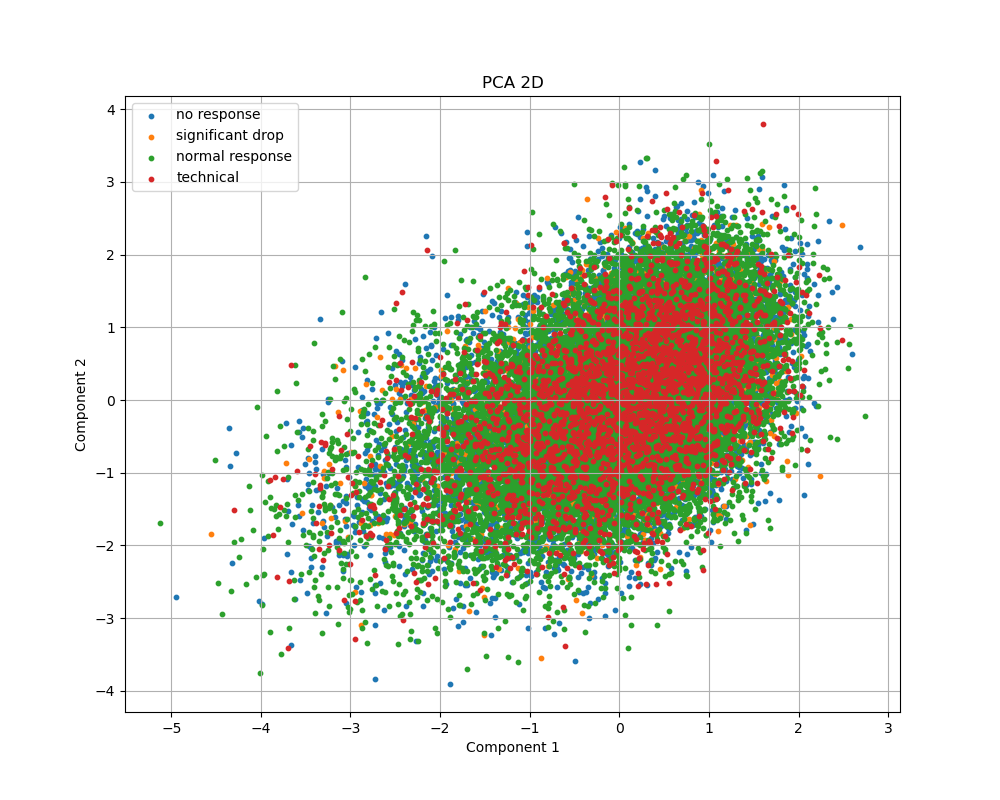

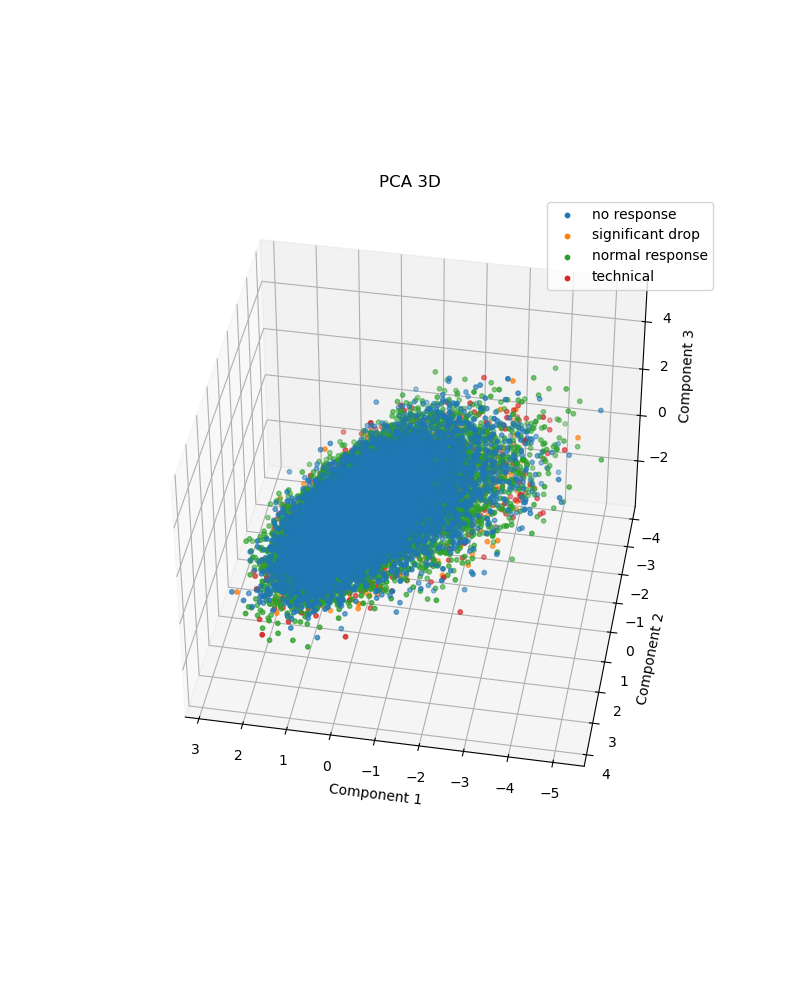

In [252]:
plot_embeddings_2d(scaled_embeddings, y_np, class_dict_labeled, "PCA 2D")
plot_embeddings_3d(scaled_embeddings, y_np, class_dict_labeled, "PCA 3D")